### import packages & define functions

In [22]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# function to group consecutive frame indices into motion events

def group_consec_frames(frame_list, max_gap=1):
    """
    frame_list: sorted list of frame indices with motion
    max_gap: max allowed gap between grames within the same event
    """

    if not frame_list:
        return []
    
    events = []
    current_event = [frame_list[0]]

    for f in frame_list[1:]:
        if f - current_event[-1] <= max_gap:
            current_event.append(f)
        else:
            events.append(current_event)
            current_event = [f]

    events.append(current_event)
    return events

In [14]:
# function to expand each motion event with padding (capture a little before and after motion event)

def expand_event(start, end, pad=10):
    return max(0, start-pad), end+pad

In [16]:
# function to clip motion events into separate video files

def save_clip(start, end, input_video, output_path):
    cap = cv2.VideoCapture(input_video)
    fps = cap.get(cv2.CAP_PROP_FPS)

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    out = cv2.VideoWriter(output_path,
                          cv2.VideoWriter_fourcc(*"mp4v"),
                          fps,
                          (width, height))
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, start)   # go to the start frame

    for f in range(start, end+1):
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)

    cap.release()
    out.release()

In [42]:
# function to extract frames from all video clips in a folder and save it into a new folder

def extract_frames(clips_dir, frames_base_dir="frames", frame_step=1):
    """
    clips_dir: folder containing all video clips
    frames_base_dir: parent folder to hold all clip frame folders
    frame_step: extract every nth frame
    """

    os.makedirs(frames_base_dir, exist_ok=True)

    for filename in os.listdir(clips_dir):
        if not filename.lower().endswith((".mp4", ".avi", ".mov", ".mkv")):
            continue
        if filename.startswith("._"):
            continue

        clip_path = os.path.join(clips_dir, filename)
        clip_name = os.path.splitext(filename)[0]
        output_dir = os.path.join(frames_base_dir, clip_name)
        os.makedirs(output_dir, exist_ok=True)

        cap = cv2.VideoCapture(clip_path)
        
        frame_index = 0
        saved_index = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_index % frame_step == 0:
                frame_filename = os.path.join(output_dir, f"frame_{saved_index:05d}.jpg")
                cv2.imwrite(frame_filename, frame)
                saved_index += 1

            frame_index += 1

        cap.release()
        print(f"saved {saved_index} frames from {filename} to {output_dir}")

### load and display first frame to get coordinates of crop region

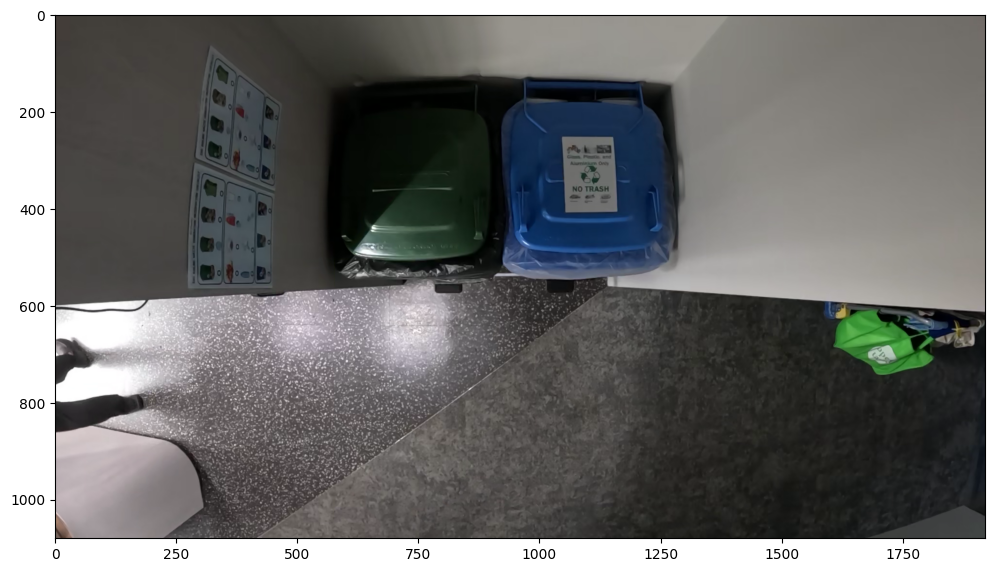

In [ ]:
input_video = "GX030079.MP4"
cap = cv2.VideoCapture(input_video)

ret, frame = cap.read()
cap.release()

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)   # convert bgr to rgb for display

plt.figure(figsize=(12, 8))
plt.imshow(frame_rgb)

### crop video to include only bins

In [ ]:
input_video = "GX030079.MP4"
cropped_video = "GX030079_cropped.MP4"

# define crop region
x1, y1 = 500, 0   # top-left corner of the crop
x2, y2 = 1400, 700 # bottom-right corner of the crop

cap = cv2.VideoCapture(input_video)   # open input video file
fourcc = cv2.VideoWriter_fourcc(*"mp4v")   # video codec used for saving the output - mp4v
fps = cap.get(cv2.CAP_PROP_FPS)   # input video fps

# create video file where cropped frames will be written
out = cv2.VideoWriter(output_video,     # output file path
                      fourcc,           # codec
                      fps,              # fps (to match input video)
                      (x2-x1, y2-y1))   # width & height of the cropped area

while True:   # read frames in a loop
    ret, frame = cap.read()   # ret = True if a frame was successfully read, False if video ended
    if not ret:   # stop when no more frames
        break
    crop = frame[y1:y2, x1:x2]
    out.write(crop)   # add cropped grame into output video file

cap.release()
out.release()

### apply motion detection to extract relevant parts of the video

In [38]:
# get frames with motion

cap = cv2.VideoCapture(cropped_video)   # open cropped video file

# mog2 learns a background model (what the scene looks like when nothing moves)
fgbg = cv2.createBackgroundSubtractorMOG2(history=500,       # how many frames are used to learn / update the background
                                          varThreshold=25)   # threshold for detecting foreground objects

frame_indices = []   # store frame number where motion is detected

frame_id = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    fgmask = fgbg.apply(frame)   # apply background subtractor to get foreground mask (white pixels - 255)
    thresh = cv2.threshold(fgmask, 200, 255,  # include anything > 200 into foreground (to account for varying greyscale intensities)
                           cv2.THRESH_BINARY)[1]

    motion_pixels = cv2.countNonZero(thresh)   # count how many pixels contain motion

    if motion_pixels > 5000:   # decide whether frame contains movement, need to adjust and see what is best
        frame_indices.append(frame_id)

    frame_id += 1   # move to the next frame

cap.release()

In [39]:
motion_events = group_consec_frames(frame_indices)   # group consecutive frames into motion events

base_name = "GX030079_cropped"

clip_id = 1
for event in motion_events[1:]:
    start, end = event[0], event[-1]

    output_path = f"{base_name}_{clip_id}.mp4"
    save_clip(start, end, cropped_video, output_path)

    print(f"saved {output_path}: frames {start} to {end}")
    clip_id += 1

saved GX030079_cropped_1.mp4: frames 110 to 259
saved GX030079_cropped_2.mp4: frames 323 to 347
saved GX030079_cropped_3.mp4: frames 3263 to 3365
saved GX030079_cropped_4.mp4: frames 3809 to 3862
saved GX030079_cropped_5.mp4: frames 4827 to 4904
saved GX030079_cropped_6.mp4: frames 5078 to 5258


### extract frames from clipped segments

In [44]:
extract_frames("GX030079_clips", "GX030079_frames")

saved 150 frames from GX030079_cropped_1.mp4 to GX030079_frames/GX030079_cropped_1
saved 25 frames from GX030079_cropped_2.mp4 to GX030079_frames/GX030079_cropped_2
saved 103 frames from GX030079_cropped_3.mp4 to GX030079_frames/GX030079_cropped_3
saved 54 frames from GX030079_cropped_4.mp4 to GX030079_frames/GX030079_cropped_4
saved 78 frames from GX030079_cropped_5.mp4 to GX030079_frames/GX030079_cropped_5
saved 181 frames from GX030079_cropped_6.mp4 to GX030079_frames/GX030079_cropped_6
